In [45]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels mpl_toolkits

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [46]:
#### Import all the needed packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting tool


In [47]:
csvFilePath = 'acc_data.csv'
df = pd.read_csv(csvFilePath)
#df = df[df['K'] == 100]

# Find NaNs in the DataFrame
#print("NaN values in DataFrame:")
#print(df.isna().sum())

# Optionally, print rows with NaNs
#print("\nRows with NaNs s:")
#print(df[df.isna().any(axis=1)])

In [48]:
def get_parameter_values(S0, K, T, r, q, sigma): 
    # d1 and d2 
    d1 = (np.log(S0/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
       
    # Lambda value 
    lambda_ = (r - q + 0.5 * sigma**2) / sigma**2
    
    # Vanilla call value
    c = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) 
    
    return lambda_, c

 
def down_and_call_book(S0, K, T, r, q, sigma,H, H_down, H_up):
    
    # Values for the different functions 
    lambda_, c = get_parameter_values(S0, K, T, r, q, sigma)
    
    # Value for the down and out
    y = np.log(H_down**2 / (S0*K)) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    
    # Values for the down and in 
    x1 = np.log(S0/H_up) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    y1 = np.log(H_up/S0) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)

    # Calculate option values for call
    if H <= K:
        #Down and out
        cdi = S0 * np.exp(-q * T) * (H_down/S0)**(2*lambda_) * norm.cdf(y) - K * np.exp(-r * T) * (H_down/S0)**(2*lambda_ - 2) * norm.cdf(y - sigma * np.sqrt(T))
        cdo = c  - cdi
        return cdo
    else:
        #Down and in
        cdo = S0 * np.exp(-q * T) * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x1 - sigma * np.sqrt(T)) 
        - S0 * np.exp(-q * T) * (H_up/S0)**(2*lambda_) * norm.cdf(y1) + K * np.exp(-r * T) * (H_up/S0)**(2*lambda_ - 2) * norm.cdf(y1 - sigma * np.sqrt(T))
        cdi = c - cdo
        
        return cdi


In [49]:
### Function for finding strictly increase but with the H_log version instead
def is_decreasing(arr):
    return all(arr[i] <= arr[i + 1] for i in range(len(arr) - 1))

def find_strictly_decrease(data, T_val, sigma_val):
    df = data[(data['sigma'] == sigma_val) & (data['T'] == T_val)]
    sorted_data = df.sort_values(by='H_log', ascending=False)
    
    if df.empty:
        return 0
    
    for i in range(len(sorted_data)):
        split_array = sorted_data.iloc[i:]
        mapped_numbers = split_array['error_percent'].astype(float).tolist()
        if is_decreasing(mapped_numbers):
            return sorted_data.iloc[i]['H_log']
            
    return 0

In [50]:

############  Exponential Regresion
# Define the exponential model for curve fitting
def exponential_model(x, a, b1, b2):
    return a * np.exp(b1 * x[0] + b2 * x[1])

# Assuming df is your DataFrame and it is already loaded with 'H_log', 'Product', and 'best_beta' columns

# Prepare the data for fitting
X = np.vstack((df['H_log'], df['Product']))  # Stack 'H_log' and 'Product' for curve fitting
y = df['best_beta'].values

# Fit the exponential model
params, _ = curve_fit(exponential_model, X, y)

# Extract the parameters
a_beta, b1_beta, b2_beta = params

# Predict values using the fitted model parameters for the initial data
y_pred_initial = exponential_model(X, a_beta, b1_beta, b2_beta)

# Linear model for Cook's distance - using OLS for simplicity
X_ols = df[['H_log', 'Product']]
X_ols = sm.add_constant(X_ols)  # Add a constant to the predictors
y_ols = df['best_beta']

# Fit OLS model
model_ols = sm.OLS(y_ols, X_ols).fit()

# Calculate Cook's distance
influence = model_ols.get_influence()
cooks_d = influence.cooks_distance[0]

# Identify points with high Cook's distance
high_cooks_d_indices = np.where(cooks_d > 4 / len(X_ols))[0]

# Filter out the influential points identified by high Cook's distance
df_filtered = df.drop(index=df.index[high_cooks_d_indices]).reset_index(drop=True)
X_filtered = np.vstack((df_filtered['H_log'], df_filtered['Product']))
y_filtered = df_filtered['best_beta'].values

# Refit the exponential model with the filtered data
params_filtered, _ = curve_fit(exponential_model, X_filtered, y_filtered)

# Predict values using the new model parameters for the filtered data
y_pred_filtered = exponential_model(X_filtered, *params_filtered)

# Calculate R-squared value for the filtered model
r_squared_filtered = r2_score(y_filtered, y_pred_filtered)

# Create a grid to evaluate the model and plot the surface
H_log_range = np.linspace(df['H_log'].min(), df['H_log'].max(), 20)
Product_range = np.linspace(df['Product'].min(), df['Product'].max(), 20)
H_log_grid, Product_grid = np.meshgrid(H_log_range, Product_range)
X_grid = np.vstack((H_log_grid.ravel(), Product_grid.ravel()))

# Predict values using the fitted model parameters for the grid
y_pred_grid = exponential_model(X_grid, *params).reshape(H_log_grid.shape)
print(f"Fitted exponential equation: best_beta = {params[0]:.4f} * exp({params[1]:.4f} * H_log + {params[2]:.4f} * Product)")

# Calculate R-squared value for the model
print(f"Model R² value: {round(r_squared_filtered, 2)}")

Fitted exponential equation: best_beta = 0.6319 * exp(-0.9384 * H_log + 0.5069 * Product)
Model R² value: 0.59


Processed 72 combinations, obtained 72 valid H values.


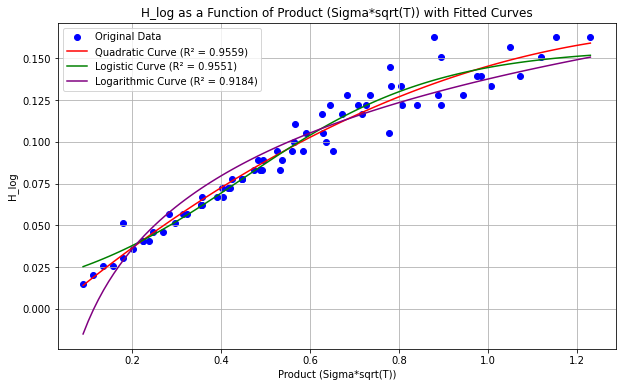

In [51]:
###### Indicator regression

# Quadratic model function
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Logistic model function
def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Logarithmic model function
def logarithmic_model(x, a, b):
    return a + b * np.log(x)

### Function for finding strictly increase but with the H_log version instead
def is_decreasing(arr):
    return all(arr[i] <= arr[i + 1] for i in range(len(arr) - 1))

def find_strictly_decrease(data, T_val, sigma_val):
    df = data[(data['sigma'] == sigma_val) & (data['T'] == T_val)]
    sorted_data = df.sort_values(by='H_log', ascending=False)
    
    if df.empty:
        return 0
    
    for i in range(len(sorted_data)):
        split_array = sorted_data.iloc[i:]
        mapped_numbers = split_array['error_percent'].astype(float).tolist()
        if is_decreasing(mapped_numbers):
            return sorted_data.iloc[i]['H_log']
            
    return 0

# Extract unique values of sigma and T from the DataFrame
unique_sigmas = df['sigma'].unique()
unique_Ts = df['T'].unique()

# Sort the arrays in case order matters for your calculations
unique_sigmas.sort()
unique_Ts.sort()

h_values = []  # Store H values
products = []  # Store corresponding product values
count = 0

# Iterate over all combinations of unique sigma and T values
for T in unique_Ts:
    for sigma in unique_sigmas:
        H_value = find_strictly_decrease(df, T, sigma)
        count += 1

        # Assuming find_strictly_decrease returns a value where positive indicates a valid result
        if float(H_value) > 0:
            h_values.append(H_value)
            products.append(abs(sigma * np.sqrt(T)))

print(f"Processed {count} combinations, obtained {len(h_values)} valid H values.")

# Convert lists to numpy arrays for curve fitting
h_values = np.array(h_values)
products = np.array(products)

# Fit the quadratic model to the data
popt_quad, _ = curve_fit(quadratic_model, products, h_values)
predicted_values_quad = quadratic_model(products, *popt_quad)
r_squared_quad = r2_score(h_values, predicted_values_quad)

# Fit the logistic model to the data
popt_logistic, _ = curve_fit(logistic_model, products, h_values, p0=[max(h_values), 1, np.median(products)])
predicted_values_logistic = logistic_model(products, *popt_logistic)
r_squared_logistic = r2_score(h_values, predicted_values_logistic)

# Fit the logarithmic model to the data, excluding non-positive values
positive_products = products[products > 0]
positive_h_values = h_values[products > 0]
popt_log, _ = curve_fit(logarithmic_model, positive_products, positive_h_values)
predicted_values_log = logarithmic_model(positive_products, *popt_log)
r_squared_log = r2_score(positive_h_values, predicted_values_log)

# Values to pass to the indicator function
L_fitted, k_fitted, x0_fitted = popt_logistic

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(products, h_values, color='blue', label='Original Data')

# Generate x values for prediction
x_fit = np.linspace(min(products), max(products), 100)

# Plot the quadratic fitted curve
y_fit_quad = quadratic_model(x_fit, *popt_quad)
plt.plot(x_fit, y_fit_quad, color='red', label=f'Quadratic Curve (R² = {r_squared_quad:.4f})')

# Plot the logistic fitted curve
y_fit_logistic = logistic_model(x_fit, *popt_logistic)
plt.plot(x_fit, y_fit_logistic, color='green', label=f'Logistic Curve (R² = {r_squared_logistic:.4f})')


# Plot the logarithmic fitted curve (ensure x_fit is positive)
positive_x_fit = x_fit[x_fit > 0]
y_fit_log = logarithmic_model(positive_x_fit, *popt_log)
plt.plot(positive_x_fit, y_fit_log, color='purple', label=f'Logarithmic Curve (R² = {r_squared_log:.4f})')

# Add titles and labels
plt.title('H_log as a Function of Product (Sigma*sqrt(T)) with Fitted Curves')
plt.xlabel('Product (Sigma*sqrt(T))')
plt.ylabel('H_log')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
########## Adjust the barriers
def regression_beta(T, sigma, H, S0, m):
    H_log = abs(np.log(H/S0))
    prod = sigma*np.sqrt(T/m)
    
    ### Todo find a generalised function for this 
    h_increase = L_fitted / (1 + np.exp(-k_fitted * (prod - x0_fitted)))

    beta = 0.5826
    
    # From regresion_exp function
    if  H_log <= h_increase:
       #print("H increase ", H)
       #beta = 0.6319 * np.exp(-0.9384 * H_log + 0.5069 * prod)
       #beta = a_beta * np.exp(b1_beta * H_log + b2_beta * prod)
       beta=0.7

    return beta

# Function to adjust the barrier for discrete monitoring
def adjusted_barrier_custom(T, H, S0,K, sigma, m, beta):
    
    # dT should be here, it "is the time between monitoring instants", p.325, also stated in book from michael at p.628
    delta_T = T / m
    beta = regression_beta(T, sigma, H, S0, m)

    ### adjust the beta value
    H_adj_down = H * np.exp(-1 * beta * sigma * np.sqrt(delta_T))
    H_adj_up = H * np.exp(beta * sigma * np.sqrt(delta_T))

    return H_adj_down, H_adj_up

Maximum Error - Original Method: 13.4592%
Maximum Error - Custom Method: 3.8919%


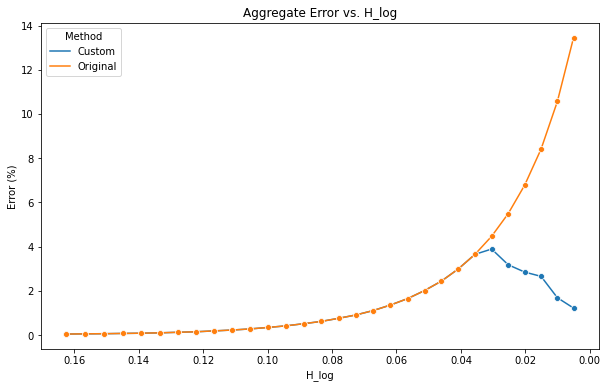

In [53]:


# Initialize a list to store error calculations
errors = []

for index, row in df.iterrows():
    q = 0
    r= 0.1 
    beta = 0.5826
    m = 50
    
    # Extract necessary values from the row
    T, H, S0, K, sigma, H_percent = row['T'], row['H'], row['S0'], row['K'], row['sigma'], row['H_log']
    
    # Calculate for custom and regular barriers
    H_down, H_up = adjusted_barrier_custom(T, H, S0, K, sigma, m, beta)
    
    price_original = row['price_adj']
    price_custom = down_and_call_book(S0, K, T, r, q, sigma, H, H_down, H_up)
    
    price_mc = row['price_iter']
    error_original = round(abs(((price_mc - price_original) / price_mc) * 100), 4)
    error_custom = round(abs(((price_mc - price_custom) / price_mc) * 100), 4)
        
    errors.append({'H_log': H_percent, 'Error': error_original, 'Type': 'Original'})
    errors.append({'H_log': H_percent, 'Error': error_custom, 'Type': 'Custom'})
    
    #print("Price ",  price_custom, "Price_iter ", price_mc,   "H ", H, "Sigma ", sigma,  "T ", T  )
    
# Convert errors list to DataFrame for plotting
df_errors = pd.DataFrame(errors)

# Aggregate errors by H_percent and Type
df_agg = df_errors.groupby(['H_log', 'Type'], as_index=False)['Error'].mean()

# Find the maximum error values for each method
max_error_original = df_agg[df_agg['Type'] == 'Original']['Error'].max()
max_error_custom = df_agg[df_agg['Type'] == 'Custom']['Error'].max()

print(f"Maximum Error - Original Method: {max_error_original:.4f}%")
print(f"Maximum Error - Custom Method: {max_error_custom:.4f}%")

# Step 3: Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_agg, x='H_log', y='Error', hue='Type', marker='o')
plt.title('Aggregate Error vs. H_log')
plt.xlabel('H_log')
plt.ylabel('Error (%)')
plt.legend(title='Method')
plt.gca().invert_xaxis()  # Invert the x-axis to have the largest H_percent start on the left
plt.show()
